In [1]:
using Plots, Serialization, Statistics, CSV, HypothesisTests, StatsBase
include("plots.jl");

Input Run Details

In [2]:
#for analysis needing pairs (augmented and baseline comparison)
augmented_run_egfr = "220"
baseline_run_egfr = "201"
augmented_run_gpcr = "200"
baseline_run_gpcr = "201";

Parameter Quantile Plots

In [3]:
#paths
gpcr_path = "./gpcr/outputs"
egfr_path = "./egfr/outputs"

#load quantiles to plot - list of tuples
gpcr_quantiles_prior = deserialize("$(gpcr_path)/600_$(augmented_run_gpcr)_prior_quantiles.jls") #could use augmented or baseline prior - same
gpcr_quantiles_posterior_baseline = deserialize("$(gpcr_path)/600_$(baseline_run_gpcr)_posterior_quantiles.jls")
gpcr_quantiles_posterior_augmented = deserialize("$(gpcr_path)/600_$(augmented_run_gpcr)_posterior_quantiles.jls")
egfr_quantiles_prior = deserialize("$(egfr_path)/600_$(augmented_run_egfr)_prior_quantiles.jls") #could use augmented or baseline prior - same
egfr_quantiles_posterior_baseline = deserialize("$(egfr_path)/600_$(baseline_run_egfr)_posterior_quantiles.jls")
egfr_quantiles_posterior_augmented = deserialize("$(egfr_path)/600_$(augmented_run_egfr)_posterior_quantiles.jls")

#load parameter names
gpcr_parameters = return_gpcr_parameters()
egfr_parameters = return_egfr_parameters()

#load reported parameter values
gpcr_reported_values = log10.(return_gpcr_parameter_values()) #molecules, sec
egfr_reported_values = log10.(return_egfr_parameter_values()) #nM, sec

#separate out binding parameters
gpcr_binding_parameter_indices = [2,1]
egfr_binding_parameter_indices = cat(egfr_return_koff_indices(),egfr_return_kon_indices(), dims=1)
m_gpcr_parameters = length(gpcr_binding_parameter_indices)
m_egfr_parameters = length(egfr_binding_parameter_indices)
n_binding_parameters = m_gpcr_parameters+m_egfr_parameters
my_quantiles_priors = cat(egfr_quantiles_prior[egfr_binding_parameter_indices], gpcr_quantiles_prior[gpcr_binding_parameter_indices], dims=1)
my_quantiles_baseline = cat(egfr_quantiles_posterior_baseline[egfr_binding_parameter_indices],gpcr_quantiles_posterior_baseline[gpcr_binding_parameter_indices], dims=1)
my_quantiles_augmented = cat(egfr_quantiles_posterior_augmented[egfr_binding_parameter_indices], gpcr_quantiles_posterior_augmented[gpcr_binding_parameter_indices], dims=1)
parameter_names = cat(egfr_parameters[egfr_binding_parameter_indices], gpcr_parameters[gpcr_binding_parameter_indices], dims=1)
ground_truth = cat(egfr_reported_values[egfr_binding_parameter_indices], gpcr_reported_values[gpcr_binding_parameter_indices], dims=1)

#plot
my_color = cat(fill(:turquoise4, m_egfr_parameters), fill(:deeppink4, m_gpcr_parameters), dims=1)

plot(dpi=300,size=(10*100, 2*100), legend=false)
for i in 1:n_binding_parameters
    plot!([i-0.25,i-0.25],my_quantiles_priors[i], alpha=0.4, linewidth=4, color=my_color[i])
    plot!([i,i],my_quantiles_baseline[i], linewidth=4, alpha=0.75, color=my_color[i], linestyle=:solid)
    plot!([i+0.25,i+0.25],my_quantiles_augmented[i], linewidth=4, linestyle=:solid, color=my_color[i])
    plot!([i-0.3,i+0.3],[ground_truth[i],ground_truth[i]], linewidth=2, color="black", linestyle=:solid)
end

xticks!(1:n_binding_parameters, parameter_names)
xlims!(0,n_binding_parameters+1)
ylims!(-6,0)
yticks!([-6,-4,-2,0])
savefig("plots/$(augmented_run_egfr)_$(baseline_run_egfr)_binding_parameter_distribution_quantiles.png");

Scatter Plots Comparing KLD

In [4]:
#load parameter names
gpcr_parameters = return_gpcr_parameters()
egfr_parameters = return_egfr_parameters()
n_gpcr_parameters = length(gpcr_parameters)
n_egfr_parameters = length(egfr_parameters)

#paths
gpcr_path = "./gpcr/outputs"
egfr_path = "./egfr/outputs"

#load dictionaries of kld from baseline to augmented
gpcr_kld = deserialize("$(gpcr_path)/600_$(augmented_run_gpcr)_$(baseline_run_gpcr)_kl_div.jls")
egfr_kld = deserialize("$(egfr_path)/600_$(augmented_run_egfr)_$(baseline_run_egfr)_kl_div.jls")

#get parameter groups by name
kld_kb = cat([egfr_kld[egfr_parameters[egfr_return_koff_indices()[i]]] for i in 1:length(egfr_return_koff_indices())],gpcr_kld[gpcr_parameters[2]],dims=1)
kld_kf = cat([egfr_kld[egfr_parameters[egfr_return_kon_indices()[i]]] for i in 1:length(egfr_return_kon_indices())],gpcr_kld[gpcr_parameters[1]],dims=1)
kld_non_binding = cat([egfr_kld[egfr_parameters[egfr_return_nonbinding_indices()[i]]] for i in 1:length(egfr_return_nonbinding_indices())],[gpcr_kld[gpcr_parameters[3:end][i]] for i in 1:length(gpcr_parameters[3:end])],dims=1);


#plot
my_linewidth = 3
my_markersize = 5
colormap = cat(fill(:turquoise4, length(kld_kb)-1),:deeppink4, dims=1)
step = 1/(length(kld_kb)-1)
x_values = collect(range(start=1, stop=2, step=step))
scatter(x_values, kld_kb, markercolor=colormap, markerstrokecolor=colormap, markersize=my_markersize)
plot!([1,2], [median(kld_kb),median(kld_kb)], color="black", linewidth=my_linewidth)
scatter!(x_values.+2, kld_kf, markercolor=colormap, markerstrokecolor=colormap,markersize=my_markersize)
plot!([1+2,2+2], [median(kld_kf),median(kld_kf)], color="black", linewidth=my_linewidth)

colormap = cat(fill(:turquoise4, length(egfr_return_nonbinding_indices())),fill(:deeppink4, n_gpcr_parameters-2), dims=1)
step = 1/(length(kld_non_binding)-1)
x_values = collect(range(start=1, stop=2, step=step))
scatter!(x_values.+4, kld_non_binding, markercolor=colormap, markerstrokecolor=colormap,markersize=my_markersize)
plot!([1+4,2+4], [median(kld_non_binding),median(kld_non_binding)], color="black", linewidth=my_linewidth)
xticks!([1.5,1.5+2,1.5+4],["kb", "kf", "nonbinding"])
ylims!(10.0^-3.5,10.0^0.5)
plot!(yscale=:log10, dpi=300, legend=false, size=(325,325), bottom_margin = 5Plots.mm)
savefig("plots/$(augmented_run_egfr)_$(baseline_run_egfr)_kl_divergence.png")

"/Users/hollyhuber/Documents/structure_informed_cell_signaling2/plots/202_203_kl_divergence.png"

Correlation Between KLD from baseline to augmented kb & KLD from prior to baseline kf

In [5]:
#load parameter names
gpcr_parameters = return_gpcr_parameters()
egfr_parameters = return_egfr_parameters()
n_gpcr_parameters = length(gpcr_parameters)
n_egfr_parameters = length(egfr_parameters)

#paths
gpcr_path = "./gpcr/outputs"
egfr_path = "./egfr/outputs"

#load dictionaries of kld from baseline to augmented
gpcr_kld = deserialize("$(gpcr_path)/600_$(augmented_run_gpcr)_$(baseline_run_gpcr)_kl_div.jls")
egfr_kld = deserialize("$(egfr_path)/600_$(augmented_run_egfr)_$(baseline_run_egfr)_kl_div.jls")

#get parameter groups by name
kld_kb_baseline_augmented = cat([egfr_kld[egfr_parameters[egfr_return_koff_indices()[i]]] for i in 1:length(egfr_return_koff_indices())],gpcr_kld[gpcr_parameters[2]],dims=1)

#load dictionaries of kld from prior to baseline
gpcr_kld = deserialize("$(gpcr_path)/600_$(baseline_run_gpcr)_prior_kl_div.jls")
egfr_kld = deserialize("$(egfr_path)/600_$(baseline_run_egfr)_prior_kl_div.jls")

#get parameter groups by name
kld_kf_prior_baseline = cat([egfr_kld[egfr_parameters[egfr_return_kon_indices()[i]]] for i in 1:length(egfr_return_kon_indices())],gpcr_kld[gpcr_parameters[1]],dims=1);

scatter(kld_kf_prior_baseline,kld_kb_baseline_augmented)
ylabel!("KL Divergence from Baseline to Augmented")
xlabel!("KL Divergence from Prior to Baseline")
savefig("plots/lack_of_correlation_between_kb_kf.png")

"/Users/hollyhuber/Documents/structure_informed_cell_signaling2/plots/lack_of_correlation_between_kb_kf.png"

Scatter Plots of Mean Absolute Error

In [6]:
#load parameter names
gpcr_parameters = return_gpcr_parameters()
egfr_parameters = return_egfr_parameters()
n_gpcr_parameters = length(gpcr_parameters)
n_egfr_parameters = length(egfr_parameters)

#paths
gpcr_path = "./gpcr/outputs"
egfr_path = "./egfr/outputs"

#load dictionaries of kld from baseline to augmented
gpcr_mae_baseline = deserialize("$(gpcr_path)/600_$(baseline_run_gpcr)_mean_absolute_error.jls")
gpcr_mae_augmented = deserialize("$(gpcr_path)/600_$(augmented_run_gpcr)_mean_absolute_error.jls")
egfr_mae_baseline = deserialize("$(egfr_path)/600_$(baseline_run_egfr)_mean_absolute_error.jls")
egfr_mae_augmented = deserialize("$(egfr_path)/600_$(augmented_run_egfr)_mean_absolute_error.jls")

#get parameter groups by name
mae_kb_baseline = cat([egfr_mae_baseline[egfr_parameters[egfr_return_koff_indices()[i]]] for i in 1:length(egfr_return_koff_indices())],gpcr_mae_baseline[gpcr_parameters[2]],dims=1)
mae_kb_augmented = cat([egfr_mae_augmented[egfr_parameters[egfr_return_koff_indices()[i]]] for i in 1:length(egfr_return_koff_indices())],gpcr_mae_augmented[gpcr_parameters[2]],dims=1)
mae_kf_baseline = cat([egfr_mae_baseline[egfr_parameters[egfr_return_kon_indices()[i]]] for i in 1:length(egfr_return_kon_indices())],gpcr_mae_baseline[gpcr_parameters[1]],dims=1)
mae_kf_augmented = cat([egfr_mae_augmented[egfr_parameters[egfr_return_kon_indices()[i]]] for i in 1:length(egfr_return_kon_indices())],gpcr_mae_augmented[gpcr_parameters[1]],dims=1)
mae_non_binding_baseline = cat([egfr_mae_baseline[egfr_parameters[egfr_return_nonbinding_indices()[i]]] for i in 1:length(egfr_return_nonbinding_indices())],[gpcr_mae_baseline[gpcr_parameters[3:end][i]] for i in 1:length(gpcr_parameters[3:end])],dims=1);
mae_non_binding_augmented = cat([egfr_mae_augmented[egfr_parameters[egfr_return_nonbinding_indices()[i]]] for i in 1:length(egfr_return_nonbinding_indices())],[gpcr_mae_augmented[gpcr_parameters[3:end][i]] for i in 1:length(gpcr_parameters[3:end])],dims=1);

#plot
my_linewidth = 3
my_markersize = 5
colormap = cat(fill(:turquoise4, length(mae_kb_baseline)-1),:deeppink4, dims=1)
step = 1/(length(mae_kb_baseline)-1)
x_values = collect(range(start=1, stop=2, step=step))
scatter(x_values.+1.25, mae_kb_augmented, markercolor=colormap, markerstrokecolor=colormap, markersize=my_markersize)
plot!([1,2].+1.25, [median(mae_kb_augmented),median(mae_kb_augmented)], color="black", linewidth=my_linewidth)
scatter!(x_values, mae_kb_baseline, markercolor=colormap, markerstrokecolor=colormap, markersize=my_markersize, alpha=0.5)
plot!([1,2], [median(mae_kb_baseline), median(mae_kb_baseline)], color="black", linewidth=my_linewidth)

offset = 1.25+2
scatter!(x_values.+offset.+1.25, mae_kf_augmented, markercolor=colormap, markerstrokecolor=colormap, markersize=my_markersize)
plot!([1,2].+offset.+1.25, [median(mae_kf_augmented),median(mae_kf_augmented)], color="black", linewidth=my_linewidth)
scatter!(x_values.+offset, mae_kf_baseline, markercolor=colormap, markerstrokecolor=colormap, markersize=my_markersize, alpha=0.5)
plot!([1,2].+offset, [median(mae_kf_baseline), median(mae_kf_baseline)], color="black", linewidth=my_linewidth)

offset = 1.25+2+1.25+2
colormap = cat(fill(:turquoise4, length(egfr_return_nonbinding_indices())),fill(:deeppink4, n_gpcr_parameters-2), dims=1)
step = 1/(length(mae_non_binding_augmented)-1)
x_values = collect(range(start=1, stop=2, step=step))
scatter!(x_values.+offset.+1.25, mae_non_binding_augmented, markercolor=colormap, markerstrokecolor=colormap,markersize=my_markersize)
plot!([1,2].+offset.+1.25, [median(mae_non_binding_augmented),median(mae_non_binding_augmented)], color="black", linewidth=my_linewidth)
scatter!(x_values.+offset, mae_non_binding_baseline, markercolor=colormap, markerstrokecolor=colormap,markersize=my_markersize, alpha=0.5)
plot!([1,2].+offset, [median(mae_non_binding_baseline),median(mae_non_binding_baseline)], color="black", linewidth=my_linewidth)

xticks!([(3.25+1)/2, (3.25+1)/2+1.25+2, (3.25+1)/2+1.25+2+1.25+2],["kb", "kf", "nonbinding"])
plot!( dpi=300, legend=false, size=(325*2,325), bottom_margin = 5Plots.mm)
ylims!(-0.1,3)
savefig("plots/$(augmented_run_egfr)_$(baseline_run_egfr)_mae.png")

"/Users/hollyhuber/Documents/structure_informed_cell_signaling2/plots/202_203_mae.png"

Statistics

In [7]:
pairs_to_test = [[kld_kb, kld_kf], [kld_kb, kld_non_binding], [kld_kf, kld_non_binding], [mae_kb_baseline, mae_kb_augmented], 
[mae_kf_baseline, mae_kf_augmented], [mae_non_binding_baseline, mae_non_binding_augmented], [mae_kf_augmented, mae_kb_augmented], 
[mae_non_binding_augmented, mae_kb_augmented], [mae_non_binding_augmented, mae_kf_augmented]]
naming_string = ["kld_kb, kld_kf", "kld_kb, kld_non_binding", "kld_kf, kld_non_binding", "mae_kb_baseline, mae_kb_augmented", 
"mae_kf_baseline, mae_kf_augmented", "mae_non_binding_baseline, mae_non_binding_augmented", "mae_kf_augmented, mae_kb_augmented", 
"mae_non_binding_augmented, mae_kb_augmented", "mae_non_binding_augmented, mae_kf_augmented"]
text_file = "\n Mann Whitney test results pvalues: \n "
test_results = [MannWhitneyUTest(pairs_to_test[i]...) for i in 1:length(pairs_to_test)];
results_string = [naming_string[i]*" pvalue: $(pvalue(test_results[i])) \n " for i in 1:length(pairs_to_test)]
serialize("plots/$(augmented_run_egfr)_$(baseline_run_egfr)_statistical_tests.txt", string(text_file, string(results_string...)))

Prediction Quantile Plots

In [8]:
color=:turquoise4
data_files = readdir("egfr/data")
sort_files = data_files .!= ".DS_Store"
data_files = sort(data_files[sort_files]) #sort to ensure consistent order
sort_files = data_files .!= "kholodenko1.xml"
data_files = sort(data_files[sort_files])
sort_files = data_files .!= "predicted_kd.csv"
data_files = sort(data_files[sort_files])
quantity_names_egfr = [replace(data_files[i], ".csv" => "") for i in 1:length(data_files)]
difference_between_medians = []

for i in quantity_names_egfr
    quantiles_augmented = deserialize("egfr/outputs/600_$(augmented_run_egfr)_prediction_quantiles_$(i).jls")
    quantiles_baseline = deserialize("egfr/outputs/600_$(baseline_run_egfr)_prediction_quantiles_$(i).jls")
    ylims, xlims, xlabel, ylabel, x_finegrain, avg_error, response, x = return_plot_inputs(i)
    p = plot_quantiles(ylims, xlims, xlabel, ylabel, x_finegrain, avg_error, response, x, color, quantiles_augmented, quantiles_baseline)
    difference_between_medians = cat(difference_between_medians, any((quantiles_augmented["median"].- quantiles_baseline["median"]) .> 5*avg_error), dims=1)
    savefig("plots/$(augmented_run_egfr)_$(baseline_run_egfr)_prediction_quantiles_$(i)")
end

In [9]:
color=:deeppink4
data_files = readdir("gpcr/data")
sort_files = data_files .!= ".DS_Store"
data_files = sort(data_files[sort_files]) #sort to ensure consistent order
sort_files = data_files .!= "predicted_kd.csv"
data_files = sort(data_files[sort_files])
quantity_names_gpcr = [replace(data_files[i], ".csv" => "") for i in 1:length(data_files)]
difference_between_medians = []

for i in quantity_names_gpcr
    quantiles_augmented = deserialize("gpcr/outputs/600_$(augmented_run_gpcr)_prediction_quantiles_$(i).jls")
    quantiles_baseline = deserialize("gpcr/outputs/600_$(baseline_run_gpcr)_prediction_quantiles_$(i).jls")
    ylims, xlims, xlabel, ylabel, x_finegrain, avg_error, response, x = return_plot_inputs(i)
    p = plot_quantiles(ylims, xlims, xlabel, ylabel, x_finegrain, avg_error, response, x, color, quantiles_augmented, quantiles_baseline)
    difference_between_medians = cat(difference_between_medians, any((quantiles_augmented["median"].- quantiles_baseline["median"]) .> 5*avg_error), dims=1)
    savefig("plots/$(augmented_run_gpcr)_$(baseline_run_gpcr)_prediction_quantiles_$(i)")
end

Prediction Quantile Plots, Species with no Experimental Data

In [10]:
color=:turquoise4
species = return_egfr_species()
n_species = length(species)
doses = return_egfr_ligand_doses_naming()
m_doses = length(doses)
quantiles_augmented = deserialize("egfr/outputs/600_$(augmented_run_egfr)_prediction_quantiles_finegrain.jls")
quantiles_baseline = deserialize("egfr/outputs/600_$(baseline_run_egfr)_prediction_quantiles_finegrain.jls")
#need finegrain timecourse for plotting, ignore other values
#same for all species
ylims, xlims, xlabel, ylabel, x_finegrain, avg_error, response, x = return_plot_inputs("p_shc_20")
for j in 1:m_doses
    if j == 1
        index = collect(range(1,23))
    elseif j == 2
        index = collect(range(24,46))
    elseif j == 3
        index = collect(range(47,69))
    end
    for i in 1:n_species
        p = plot_quantiles_no_experimental_data(species[i], x_finegrain, xlims, color, quantiles_augmented[index[i]], quantiles_baseline[index[i]])
        ylabel!("$(species[i]) (nM)")
        plot!(legend=false)
        savefig("plots/prediction_quantiles_all_species/$(augmented_run_egfr)_$(baseline_run_egfr)_prediction_quantiles_$(species[i])_$(doses[j])")
    end
end

In [11]:
color=:deeppink4
species = return_gpcr_species()
n_species = length(species)
doses = return_gpcr_ligand_doses_naming()
m_doses = length(doses)
quantiles_augmented = deserialize("gpcr/outputs/600_$(augmented_run_gpcr)_prediction_quantiles_finegrain.jls")
quantiles_baseline = deserialize("gpcr/outputs/600_$(baseline_run_gpcr)_prediction_quantiles_finegrain.jls")
#need finegrain timecourse for plotting, ignore other values
#same for all species
ylims, xlims, xlabel, ylabel, x_finegrain, avg_error, response, x = return_plot_inputs("active_g_timecourse")
for j in 1:m_doses
    if j == 1
        index = collect(range(1,5))
    elseif j == 2
        index = collect(range(6,10))
    elseif j == 3
        index = collect(range(11,15))
    elseif j == 4
        index = collect(range(16,20))
    elseif j == 5
        index = collect(range(21,25))
    elseif j == 6
        index = collect(range(26,30))
    elseif j == 7
        index = collect(range(31,35))
    elseif j == 8
        index = collect(range(36,40))
    elseif j == 9
        index = collect(range(41,45))
    end
    for i in 1:n_species
        if species[i] != "L" #L held constant
            p = plot_quantiles_no_experimental_data(species[i], x_finegrain, xlims, color, quantiles_augmented[index[i]], quantiles_baseline[index[i]])
            ylabel!("$(species[i]) molecules")
            plot!(legend=false)
            savefig("plots/prediction_quantiles_all_species/$(augmented_run_gpcr)_$(baseline_run_gpcr)_prediction_quantiles_$(species[i])_$(doses[j])")
        end
    end
end

LoadError: SystemError: opening file "gpcr/outputs/600_202_prediction_quantiles_finegrain.jls": No such file or directory

Local Sensitivity Analysis - Pearson

In [3]:
gpcr_median_difference = deserialize("gpcr/outputs/600_$(baseline_run_gpcr)_$(augmented_run_gpcr)_difference_between_medians_1d.jls")
egfr_median_difference = deserialize("egfr/outputs/600_$(baseline_run_egfr)_$(augmented_run_egfr)_difference_between_medians_1d.jls")

parameter_functions = ["kb", "kf", "nonbind"]
egfr_test = []
gpcr_test = []
for i in parameter_functions
    gpcr_local_sensitivity = deserialize("gpcr/outputs/600_$(baseline_run_gpcr)_local_sensitivity_$(i)_1d.jls")
    egfr_local_sensitivity = deserialize("egfr/outputs/600_$(baseline_run_egfr)_local_sensitivity_$(i)_1d.jls")
    #sort out zeros, which correspond to t=0
    gpcr_mask = gpcr_local_sensitivity .!= 0.0
    egfr_mask = egfr_local_sensitivity .!= 0.0
    egfr_test = cat(egfr_test, [CorrelationTest(egfr_local_sensitivity[egfr_mask], egfr_median_difference[egfr_mask])], dims=1)
    gpcr_test = cat(gpcr_test, [CorrelationTest(gpcr_local_sensitivity[gpcr_mask], gpcr_median_difference[gpcr_mask])], dims=1)
end
egfr_pearson_r = [egfr_test[i].r for i in 1:length(egfr_test)]
gpcr_pearson_r = [gpcr_test[i].r for i in 1:length(gpcr_test)]
egfr_pearson_p = [pvalue(egfr_test[i]) for i in 1:length(egfr_test)]
gpcr_pearson_p = [pvalue(gpcr_test[i]) for i in 1:length(gpcr_test)]
#generate string to save as txt file
string_text = ["\nPearson's correlation between local sensitivity of output vs. \ndifference between medians of augmented and baseline approaches for same output \n"," 
\negfr: \n"]
egfr = ["$(parameter_functions[i]): row = $(egfr_pearson_r[i]), pvalue = $(egfr_pearson_p[i]) \n" for i in 1:3]
gpcr = ["$(parameter_functions[i]): row = $(gpcr_pearson_r[i]), pvalue = $(gpcr_pearson_p[i]) \n" for i in 1:3]
all_string = string(string_text... , egfr...," \ngpcr: \n", gpcr...)
open("plots/$(augmented_run_egfr)_$(baseline_run_egfr)_statistical_tests_sensitivity.txt", "w") do file
    write(file, all_string)
end

#gpcr scatter plot
color_pal = palette([:black, :white, :deeppink4], 200);
for i in 1:length(parameter_functions)
    index = Int(round(gpcr_pearson_r[i]*100)+100)
    color = color_pal[index]
    local_sensitivity = deserialize("gpcr/outputs/600_$(baseline_run_gpcr)_local_sensitivity_$(parameter_functions[i])_1d.jls")
    p = sensitivity_scatter_plot(local_sensitivity, gpcr_median_difference, color)
    plot!(legend=false)
    savefig("plots/$(augmented_run_gpcr)_$(baseline_run_gpcr)_gpcr_sensitivity_scatter_plot_$(parameter_functions[i]).png")
end

#egfr scatter plot
color_pal = palette([:black,:white,:turquoise4], 200);
for i in 1:length(parameter_functions)
    index = Int(round(egfr_pearson_r[i]*100)+100)
    color = color_pal[index]
    local_sensitivity = (deserialize("egfr/outputs/600_$(baseline_run_egfr)_local_sensitivity_$(parameter_functions[i])_1d.jls"))
    p = sensitivity_scatter_plot(local_sensitivity, egfr_median_difference, color)
    plot!(legend=false)
    savefig("plots/$(augmented_run_egfr)_$(baseline_run_egfr)_egfr_sensitivity_scatter_plot_$(parameter_functions[i]).png")
end

heatmap(reshape(gpcr_pearson_r, (1,3)), c=palette([ :black, :white, :deeppink4], 200), clims=(-1,1))
plot!(size=(690,690/3), dpi=300)
savefig("plots/$(augmented_run_gpcr)_$(baseline_run_gpcr)_gpcr_sensitivity_heatmap.png")

heatmap(reshape(egfr_pearson_r, (1,3)), c=palette([ :black, :white, :turquoise4], 200), clims=(-1,1))
plot!(size=(690,690/3), dpi=300)
savefig("plots/$(augmented_run_egfr)_$(baseline_run_egfr)_egfr_sensitivity_heatmap.png")

"/Users/hollyhuber/Documents/structure_informed_cell_signaling/plots/220_201_egfr_sensitivity_heatmap.png"

Local Sensitivity Analysis - Spearman

In [29]:
#tie rank for spearman correlation rather than pearson
gpcr_median_difference = deserialize("gpcr/outputs/600_$(baseline_run_gpcr)_$(augmented_run_gpcr)_difference_between_medians_1d.jls")
egfr_median_difference = deserialize("egfr/outputs/600_$(baseline_run_egfr)_$(augmented_run_egfr)_difference_between_medians_1d.jls");

parameter_functions = ["kb", "kf", "nonbind"]
egfr_test = []
gpcr_test = []
for i in parameter_functions
    gpcr_local_sensitivity = log10.(deserialize("gpcr/outputs/600_$(baseline_run_gpcr)_local_sensitivity_$(i)_1d.jls"))
    egfr_local_sensitivity = log10.(deserialize("egfr/outputs/600_$(baseline_run_egfr)_local_sensitivity_$(i)_1d.jls"))
    #sort out zeros, which correspond to t=0
    gpcr_mask = gpcr_local_sensitivity .!= 0.0
    egfr_mask = egfr_local_sensitivity .!= 0.0
    egfr_test = cat(egfr_test, [CorrelationTest(StatsBase.tiedrank(egfr_local_sensitivity[egfr_mask]), StatsBase.tiedrank(egfr_median_difference[egfr_mask]))], dims=1)
    gpcr_test = cat(gpcr_test, [CorrelationTest(StatsBase.tiedrank(gpcr_local_sensitivity[gpcr_mask]), StatsBase.tiedrank(gpcr_median_difference[gpcr_mask]))], dims=1)
end
egfr_spearman_r = [egfr_test[i].r for i in 1:length(egfr_test)]
gpcr_spearman_r = [gpcr_test[i].r for i in 1:length(gpcr_test)]
egfr_spearman_p = [pvalue(egfr_test[i]) for i in 1:length(egfr_test)]
gpcr_spearman_p = [pvalue(gpcr_test[i]) for i in 1:length(gpcr_test)]
#generate string to save as txt file
string_text = ["\nSpearman's correlation between local sensitivity of output vs. \ndifference between medians of augmented and baseline approaches for same output \n"," 
\negfr: \n"]
egfr = ["$(parameter_functions[i]): row = $(egfr_spearman_r[i]), pvalue = $(egfr_spearman_p[i]) \n" for i in 1:3]
gpcr = ["$(parameter_functions[i]): row = $(gpcr_spearman_r[i]), pvalue = $(gpcr_spearman_p[i]) \n" for i in 1:3]
all_string = string(string_text... , egfr...," \ngpcr: \n", gpcr...)
open("plots/$(augmented_run_egfr)_$(baseline_run_egfr)_statistical_tests_sensitivity.txt", "w") do file
    write(file, all_string)
end

#gpcr scatter plot
color_pal = palette([:black, :white, :deeppink4], 200);
for i in 1:length(parameter_functions)
    index = Int(round(gpcr_spearman_r[i]*100)+100)
    color = color_pal[index]
    local_sensitivity = deserialize("gpcr/outputs/600_$(baseline_run_gpcr)_local_sensitivity_$(parameter_functions[i])_1d.jls")
    p = sensitivity_scatter_plot(local_sensitivity, gpcr_median_difference, color)
    plot!(legend=false)
    savefig("plots/$(augmented_run_gpcr)_$(baseline_run_gpcr)_gpcr_sensitivity_scatter_plot_$(parameter_functions[i]).png")
end

#egfr scatter plot
color_pal = palette([:black,:white,:turquoise4], 200);
for i in 1:length(parameter_functions)
    index = Int(round(egfr_spearman_r[i]*100)+100)
    color = color_pal[index]
    local_sensitivity = deserialize("egfr/outputs/600_$(baseline_run_egfr)_local_sensitivity_$(parameter_functions[i])_1d.jls")
    p = sensitivity_scatter_plot(local_sensitivity, egfr_median_difference, color)
    plot!(legend=false)
    savefig("plots/$(augmented_run_egfr)_$(baseline_run_egfr)_egfr_sensitivity_scatter_plot_$(parameter_functions[i]).png")
end

heatmap(reshape(gpcr_spearman_r, (1,3)), c=palette([ :black, :white, :deeppink4], 200), clims=(-1,1))
plot!(size=(690,690/3), dpi=300)
savefig("plots/$(augmented_run_gpcr)_$(baseline_run_gpcr)_gpcr_sensitivity_heatmap.png")

heatmap(reshape(egfr_spearman_r, (1,3)), c=palette([ :black, :white, :turquoise4], 200), clims=(-1,1))
plot!(size=(690,690/3), dpi=300)
savefig("plots/$(augmented_run_egfr)_$(baseline_run_egfr)_egfr_sensitivity_heatmap.png")

"/Users/hollyhuber/Documents/structure_informed_cell_signaling/plots/220_201_egfr_sensitivity_heatmap.png"

Global Sensitivity Analysis

In [17]:
gpcr_median_difference = deserialize("gpcr/outputs/600_$(baseline_run_gpcr)_$(augmented_run_gpcr)_difference_between_medians_1d.jls")
egfr_median_difference = deserialize("egfr/outputs/600_$(baseline_run_egfr)_$(augmented_run_egfr)_difference_between_medians_1d.jls");

parameter_functions = ["kb", "kf", "nonbind"]
egfr_test = []
gpcr_test = []
for i in parameter_functions
    gpcr_local_sensitivity = vec(deserialize("gpcr/outputs/600_$(baseline_run_gpcr)_global_sensitivity_about_max_likelihood_value_S1_$(i).jls"))
    egfr_local_sensitivity = vec(deserialize("egfr/outputs/600_$(baseline_run_egfr)_global_sensitivity_about_max_likelihood_value_S1_$(i).jls"))
    egfr_test = cat(egfr_test, [CorrelationTest(egfr_local_sensitivity, egfr_median_difference)], dims=1)
    gpcr_test = cat(gpcr_test, [CorrelationTest(gpcr_local_sensitivity, gpcr_median_difference)], dims=1)
end
egfr_pearson_r = [egfr_test[i].r for i in 1:length(egfr_test)]
gpcr_pearson_r = [gpcr_test[i].r for i in 1:length(gpcr_test)]
egfr_pearson_p = [pvalue(egfr_test[i]) for i in 1:length(egfr_test)]
gpcr_pearson_p = [pvalue(gpcr_test[i]) for i in 1:length(gpcr_test)]
#generate string to save as txt file
string_text = ["\nPearson's correlation between global sensitivity of output vs. \ndifference between medians of augmented and baseline approaches for same output \n"," 
\negfr: \n"]
egfr = ["$(parameter_functions[i]): row = $(egfr_pearson_r[i]), pvalue = $(egfr_pearson_p[i]) \n" for i in 1:3]
gpcr = ["$(parameter_functions[i]): row = $(gpcr_pearson_r[i]), pvalue = $(gpcr_pearson_p[i]) \n" for i in 1:3]
all_string = string(string_text... , egfr...," \ngpcr: \n", gpcr...)
open("plots/$(augmented_run_egfr)_$(baseline_run_egfr)_statistical_tests_global_sensitivity.txt", "w") do file
    write(file, all_string);
end

546

Correlation Between Timepoint and Change in Median

In [18]:
gpcr_median_difference = deserialize("gpcr/outputs/600_$(baseline_run_gpcr)_$(augmented_run_gpcr)_difference_between_medians_1d.jls")
egfr_median_difference = deserialize("egfr/outputs/600_$(baseline_run_egfr)_$(augmented_run_egfr)_difference_between_medians_1d.jls")
egfr_timepoints = [0, 15, 30, 45, 60, 120]
gpcr_timepoints = [0, 10, 30, 60, 120, 210, 300, 450, 600]
n_gpcr_repeats = Int(length(gpcr_median_difference)/length(gpcr_timepoints))
n_egfr_repeats = Int(length(egfr_median_difference)/length(egfr_timepoints))
gpcr_time_vector = repeat(gpcr_timepoints, n_gpcr_repeats)
egfr_time_vector = repeat(egfr_timepoints, n_egfr_repeats)

#save scatter plots
scatter(gpcr_time_vector, gpcr_median_difference, color=:deeppink4, legend=false)
plot!(size=(690,690), dpi=300)
savefig("plots/$(augmented_run_gpcr)_$(baseline_run_gpcr)_gpcr_time_v_change_median_scatter.png")
scatter(egfr_time_vector, egfr_median_difference, color=:turquoise4, legend=false)
plot!(size=(690,690), dpi=300)
savefig("plots/$(augmented_run_egfr)_$(baseline_run_egfr)_egfr_time_v_change_median_scatter.png")

"/Users/hollyhuber/Documents/structure_informed_cell_signaling/plots/220_201_egfr_time_v_change_median_scatter.png"

In [19]:
Statistics.cor(gpcr_median_difference, gpcr_time_vector)

0.31305665177439573

In [20]:
Statistics.cor(egfr_median_difference, egfr_time_vector)

-0.04373543266052037

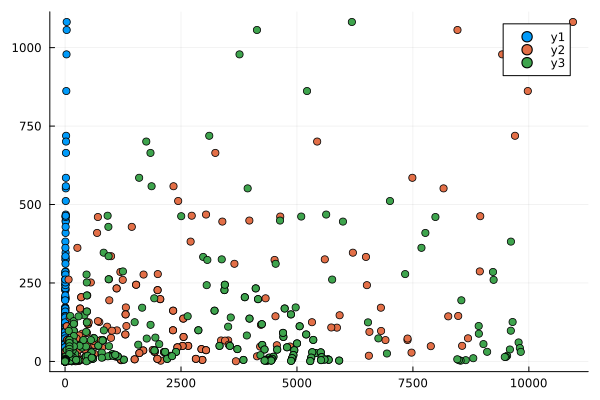

In [ ]:
gpcr_local_sensitivity_kb = deserialize("gpcr/outputs/600_$(baseline_run_gpcr)_local_sensitivity_kb_1d.jls")
gpcr_local_sensitivity_kf = deserialize("gpcr/outputs/600_$(baseline_run_gpcr)_local_sensitivity_kf_1d.jls")
gpcr_local_sensitivity_nonbind = deserialize("gpcr/outputs/600_$(baseline_run_gpcr)_local_sensitivity_nonbind_1d.jls");
scatter(gpcr_local_sensitivity_kb, gpcr_median_difference)
scatter!(gpcr_local_sensitivity_kf, gpcr_median_difference)
scatter!(gpcr_local_sensitivity_nonbind, gpcr_median_difference)

In [ ]:
scatter(gpcr_local_sensitivity_kb[gpcr_kb_mask], gpcr_median_difference[gpcr_kb_mask])
scatter!(gpcr_local_sensitivity_kf[gpcr_kf_mask], gpcr_median_difference[gpcr_kf_mask])
scatter!(gpcr_local_sensitivity_nonbind[gpcr_nonbind_mask], gpcr_median_difference[gpcr_nonbind_mask])

LoadError: UndefVarError: `gpcr_kb_mask` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
CorrelationTest(gpcr_local_sensitivity_nonbind[gpcr_nonbind_mask], gpcr_median_difference[gpcr_nonbind_mask])

Test for nonzero correlation
----------------------------
Population details:
    parameter of interest:   Correlation
    value under h_0:         0.0
    point estimate:          0.129163
    95% confidence interval: (0.01379, 0.2411)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0284

Details:
    number of observations:          288
    number of conditional variables: 0
    t-statistic:                     2.2028
    degrees of freedom:              286


In [ ]:
gpcr_kb_mask = gpcr_local_sensitivity_kb .>= 1e-10
gpcr_kf_mask = gpcr_local_sensitivity_kf .>= 1e-10
gpcr_nonbind_mask = gpcr_local_sensitivity_nonbind .>= 1e-10;

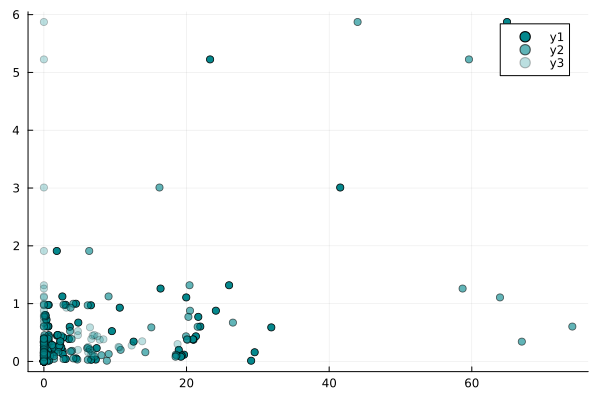

In [ ]:
egfr_local_sensitivity_kb = deserialize("egfr/outputs/600_$(baseline_run_gpcr)_local_sensitivity_kb_1d.jls")
egfr_local_sensitivity_kf = deserialize("egfr/outputs/600_$(baseline_run_gpcr)_local_sensitivity_kf_1d.jls")
egfr_local_sensitivity_nonbind = deserialize("egfr/outputs/600_$(baseline_run_gpcr)_local_sensitivity_nonbind_1d.jls");
scatter(egfr_local_sensitivity_kb, egfr_median_difference, alpha=gpcr_pearson_r[1], color=:turquoise4)
scatter!(egfr_local_sensitivity_kf, egfr_median_difference, alpha=gpcr_pearson_r[2], color=:turquoise4)
scatter!(egfr_local_sensitivity_nonbind, egfr_median_difference, alpha=gpcr_pearson_r[3], color=:turquoise4)

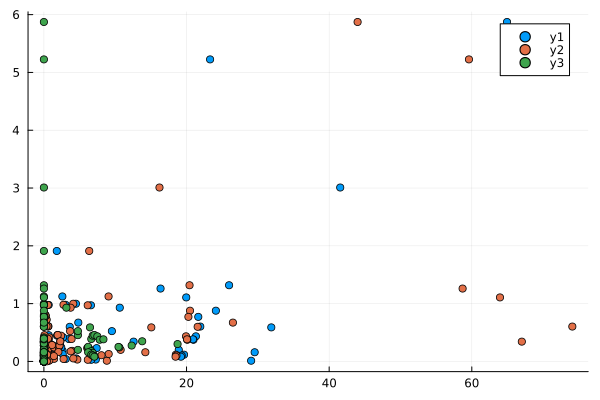

In [ ]:
scatter(egfr_local_sensitivity_kb, egfr_median_difference)
scatter!(egfr_local_sensitivity_kf, egfr_median_difference)
scatter!(egfr_local_sensitivity_nonbind, egfr_median_difference)

In [ ]:
egfr_kb_mask = egfr_local_sensitivity_kb .>= 1e-10
egfr_kf_mask = egfr_local_sensitivity_kf .>= 1e-10
egfr_nonbind_mask = egfr_local_sensitivity_nonbind .>= 1e-10;

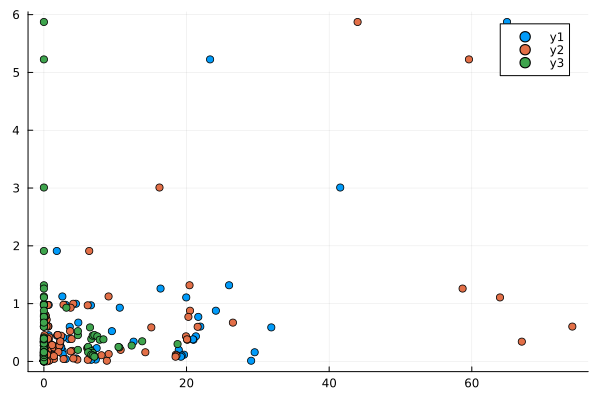

In [ ]:
scatter(egfr_local_sensitivity_kb[egfr_kb_mask], egfr_median_difference[egfr_kb_mask])
scatter!(egfr_local_sensitivity_kf[egfr_kf_mask], egfr_median_difference[egfr_kf_mask])
scatter!(egfr_local_sensitivity_nonbind[egfr_nonbind_mask], egfr_median_difference[egfr_nonbind_mask])

In [ ]:
CorrelationTest(egfr_local_sensitivity_kb[egfr_kb_mask], egfr_median_difference[egfr_kb_mask])

Test for nonzero correlation
----------------------------
Population details:
    parameter of interest:   Correlation
    value under h_0:         0.0
    point estimate:          0.637693
    95% confidence interval: (0.5147, 0.735)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-13

Details:
    number of observations:          115
    number of conditional variables: 0
    t-statistic:                     8.80027
    degrees of freedom:              113
